In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 
from sklearn.ensemble import RandomForestRegressor



## Data importation

In [2]:
df_1 = pd.read_csv('dataset_v2.csv',low_memory=False)

In [3]:
df_1

,datetime,zipcode,datetime.1,change,rental,date,time,parking_size,num_of_muni,temp,...,June,July,August,September,October,November,Hour,Days Passed,Commute In,Commute Out
0,2018-01-31 22:00:00,94114,2018-01-31 22:00:00,-1,4,2018-01-31,22,44.012042,156,12.2,...,0,0,0,0,0,0,742.0,30,0,0
1,2018-01-31 23:00:00,94114,2018-01-31 23:00:00,-1,1,2018-01-31,23,44.012042,156,12.8,...,0,0,0,0,0,0,743.0,30,0,0
2,2018-01-31 21:00:00,94114,2018-01-31 21:00:00,2,3,2018-01-31,21,44.012042,156,12.2,...,0,0,0,0,0,0,741.0,30,0,0
3,2018-01-31 20:00:00,94114,2018-01-31 20:00:00,2,1,2018-01-31,20,44.012042,156,13.3,...,0,0,0,0,0,0,740.0,30,0,0
4,2018-01-31 19:00:00,94114,2018-01-31 19:00:00,1,7,2018-01-31,19,44.012042,156,13.9,...,0,0,0,0,0,0,739.0,30,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452567,2019-06-25 09:00:00,95132,2019-06-25 09:00:00,1,0,2019-06-25,9,0.000000,0,18.3,...,1,0,0,0,0,0,12969.0,540,1,0
452568,2019-06-27 15:00:00,95054,2019-06-27 15:00:00,1,0,2019-06-27,15,0.000000,0,20.6,...,1,0,0,0,0,0,13023.0,542,0,0
452569,2019-06-23 17:00:00,95054,2019-06-23 17:00:00,1,0,2019-06-23,17,0.000000,0,23.9,...,1,0,0,0,0,0,12929.0,538,0,0
452570,2019-06-21 21:00:00,95054,2019-06-21 21:00:00,2,0,2019-06-21,21,0.000000,0,14.4,...,1,0,0,0,0,0,12885.0,536,0,0


In [4]:
def OSR2(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

In [5]:
def OSR2_linreg(model, df_train, df_test, dependent_var):   
    
    y_test = df_test[dependent_var]
    y_pred = model.predict(df_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(df_train[dependent_var]))**2)    
    
    return 1 - SSE/SST

## Predicting overall number of rentals

### Data formatting

In [6]:
df3=df_1.copy()

In [7]:
df3=df3[df3['date']>="2019-01-01"]
df3=df3[df3['date']<="2019-05-31"]

In [8]:
df3['datetime'] = df3['datetime'].astype('str')
df3['datetime'] = pd.to_datetime(df3['datetime'])
df3['pres']=df3['pres'].fillna(method='ffill')
df3=df3.rename(columns={"Business Day": "business_day", "Days Passed": "days_passed", "Commute In": "commute_in", "Commute Out": "commute_out"})
df3.drop(columns=['parking_size','num_of_muni','zipcode'], inplace=True)
df3

,datetime,datetime.1,change,rental,date,time,temp,dwpt,rhum,prcp,...,June,July,August,September,October,November,Hour,days_passed,commute_in,commute_out
265464,2019-01-01 15:00:00,2019-01-01 15:00:00,1,0,2019-01-01,15,12.2,-4.0,32,0.0,...,0,0,0,0,0,0,8775.0,365,0,0
266084,2019-01-01 12:00:00,2019-01-01 12:00:00,1,0,2019-01-01,12,10.0,-5.6,33,0.0,...,0,0,0,0,0,0,8772.0,365,0,0
266086,2019-01-01 08:00:00,2019-01-01 08:00:00,1,0,2019-01-01,8,8.3,-5.6,37,0.0,...,0,0,0,0,0,0,8768.0,365,0,0
266241,2019-01-01 00:00:00,2019-01-01 00:00:00,2,0,2019-01-01,0,10.6,-2.8,39,0.0,...,0,0,0,0,0,0,8760.0,365,0,0
266848,2019-01-01 03:00:00,2019-01-01 03:00:00,1,0,2019-01-01,3,9.4,-2.2,44,0.0,...,0,0,0,0,0,0,8763.0,365,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425157,2019-05-07 18:00:00,2019-05-07 18:00:00,-1,1,2019-05-07,18,16.7,9.4,62,0.0,...,0,0,0,0,0,0,11802.0,491,0,1
425158,2019-05-04 14:00:00,2019-05-04 14:00:00,-1,1,2019-05-04,14,17.8,7.8,52,0.0,...,0,0,0,0,0,0,11726.0,488,0,0
425159,2019-05-04 13:00:00,2019-05-04 13:00:00,0,1,2019-05-04,13,16.7,8.4,58,0.0,...,0,0,0,0,0,0,11725.0,488,0,0
425160,2019-05-08 17:00:00,2019-05-08 17:00:00,-1,1,2019-05-08,17,16.1,10.6,70,0.0,...,0,0,0,0,0,0,11825.0,492,0,1


In [9]:
df_train_o=df3[df3['date']<="2019-05-10"]
df_test_o=df3[df3['date']>"2019-05-10"]

In [10]:
#cols=['time','temp', 'dwpt', 'rhum', 'prcp' ,'wdir' , 'wspd' , 'pres' , 'business_day' , 'Holiday' , 'Spring' , 'Summer' , 'Fall' , 'Monday' , 'Tuesday' , 'Wednesday' , 'Thursday' , 'Friday' , 'Saturday' , 'January' , 'February' , 'March' , 'April' , 'May' , 'June' , 'July' , 'August' , 'September' , 'October' , 'November' , 'Hour' , 'commute_in' , 'commute_out' , 'days_passed']
df4=df3.groupby(['datetime']).agg({'time':'mean','temp':'mean', 'dwpt':'mean', 'rhum':'mean', 'prcp':'mean' ,'wdir':'mean' , 'wspd':'mean' , 'pres':'mean' , 'business_day':'mean' , 'Holiday':'mean' , 'Spring':'mean' , 'Summer':'mean' , 'Fall':'mean' , 'Monday':'mean' , 'Tuesday':'mean' , 'Wednesday':'mean' , 'Thursday':'mean' , 'Friday':'mean' , 'Saturday':'mean' , 'January':'mean' , 'February':'mean' , 'March':'mean' , 'April':'mean' , 'May':'mean' , 'June':'mean' , 'July':'mean' , 'August':'mean' , 'September':'mean' , 'October':'mean' , 'November':'mean' , 'Hour':'mean' , 'commute_in':'mean' , 'commute_out':'mean' , 'days_passed':'mean' , 'change': 'sum','rental':'sum'})
df4

,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,business_day,Holiday,...,August,September,October,November,Hour,commute_in,commute_out,days_passed,change,rental
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.0,10.6,-2.8,39.0,0.0,20.0,29.5,1018.8,0.0,1.0,...,0.0,0.0,0.0,0.0,8760.0,0.0,0.0,365.0,-1,71
2019-01-01 01:00:00,1.0,10.6,-3.1,38.0,0.0,360.0,31.7,1019.3,0.0,1.0,...,0.0,0.0,0.0,0.0,8761.0,0.0,0.0,365.0,-16,92
2019-01-01 02:00:00,2.0,10.0,-3.3,39.0,0.0,10.0,29.5,1019.9,0.0,1.0,...,0.0,0.0,0.0,0.0,8762.0,0.0,0.0,365.0,13,56
2019-01-01 03:00:00,3.0,9.4,-2.2,44.0,0.0,10.0,37.1,1020.8,0.0,1.0,...,0.0,0.0,0.0,0.0,8763.0,0.0,0.0,365.0,10,18
2019-01-01 04:00:00,4.0,8.9,-2.7,44.0,0.0,360.0,33.5,1021.3,0.0,1.0,...,0.0,0.0,0.0,0.0,8764.0,0.0,0.0,365.0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-31 19:00:00,19.0,13.3,9.9,80.0,0.0,300.0,27.7,1010.1,1.0,0.0,...,0.0,0.0,0.0,0.0,12379.0,0.0,0.0,515.0,54,340
2019-05-31 20:00:00,20.0,12.8,10.0,83.0,0.0,300.0,25.9,1010.5,1.0,0.0,...,0.0,0.0,0.0,0.0,12380.0,0.0,0.0,515.0,13,220
2019-05-31 21:00:00,21.0,12.2,9.9,86.0,0.0,300.0,27.7,1011.0,1.0,0.0,...,0.0,0.0,0.0,0.0,12381.0,0.0,0.0,515.0,17,165


In [11]:
df_test_o=df_test_o.groupby(['datetime']).agg({'time':'mean','temp':'mean', 'dwpt':'mean', 'rhum':'mean', 'prcp':'mean' ,'wdir':'mean' , 'wspd':'mean' , 'pres':'mean' , 'business_day':'mean' , 'Holiday':'mean' , 'Spring':'mean' , 'Summer':'mean' , 'Fall':'mean' , 'Monday':'mean' , 'Tuesday':'mean' , 'Wednesday':'mean' , 'Thursday':'mean' , 'Friday':'mean' , 'Saturday':'mean' , 'January':'mean' , 'February':'mean' , 'March':'mean' , 'April':'mean' , 'May':'mean' , 'June':'mean' , 'July':'mean' , 'August':'mean' , 'September':'mean' , 'October':'mean' , 'November':'mean' , 'Hour':'mean' , 'commute_in':'mean' , 'commute_out':'mean' , 'days_passed':'mean' , 'change': 'sum','rental':'sum'})
df_train_o=df_train_o.groupby(['datetime']).agg({'time':'mean','temp':'mean', 'dwpt':'mean', 'rhum':'mean', 'prcp':'mean' ,'wdir':'mean' , 'wspd':'mean' , 'pres':'mean' , 'business_day':'mean' , 'Holiday':'mean' , 'Spring':'mean' , 'Summer':'mean' , 'Fall':'mean' , 'Monday':'mean' , 'Tuesday':'mean' , 'Wednesday':'mean' , 'Thursday':'mean' , 'Friday':'mean' , 'Saturday':'mean' , 'January':'mean' , 'February':'mean' , 'March':'mean' , 'April':'mean' , 'May':'mean' , 'June':'mean' , 'July':'mean' , 'August':'mean' , 'September':'mean' , 'October':'mean' , 'November':'mean' , 'Hour':'mean' , 'commute_in':'mean' , 'commute_out':'mean' , 'days_passed':'mean' , 'change': 'sum','rental':'sum'})

In [12]:
df4.reset_index(level=0,inplace=True)
df_train_o.reset_index(level=0,inplace=True)
df_test_o.reset_index(level=0,inplace=True)
df_train_o

,datetime,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,business_day,...,August,September,October,November,Hour,commute_in,commute_out,days_passed,change,rental
0,2019-01-01 00:00:00,0.0,10.6,-2.8,39.0,0.0,20.0,29.5,1018.8,0.0,...,0.0,0.0,0.0,0.0,8760.0,0.0,0.0,365.0,-1,71
1,2019-01-01 01:00:00,1.0,10.6,-3.1,38.0,0.0,360.0,31.7,1019.3,0.0,...,0.0,0.0,0.0,0.0,8761.0,0.0,0.0,365.0,-16,92
2,2019-01-01 02:00:00,2.0,10.0,-3.3,39.0,0.0,10.0,29.5,1019.9,0.0,...,0.0,0.0,0.0,0.0,8762.0,0.0,0.0,365.0,13,56
3,2019-01-01 03:00:00,3.0,9.4,-2.2,44.0,0.0,10.0,37.1,1020.8,0.0,...,0.0,0.0,0.0,0.0,8763.0,0.0,0.0,365.0,10,18
4,2019-01-01 04:00:00,4.0,8.9,-2.7,44.0,0.0,360.0,33.5,1021.3,0.0,...,0.0,0.0,0.0,0.0,8764.0,0.0,0.0,365.0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113,2019-05-10 19:00:00,19.0,15.0,10.0,72.0,0.0,280.0,33.5,1011.0,1.0,...,0.0,0.0,0.0,0.0,11875.0,0.0,0.0,494.0,27,354
3114,2019-05-10 20:00:00,20.0,13.9,9.3,74.0,0.0,280.0,27.7,1011.9,1.0,...,0.0,0.0,0.0,0.0,11876.0,0.0,0.0,494.0,11,230
3115,2019-05-10 21:00:00,21.0,14.4,9.4,72.0,0.0,290.0,16.6,1012.4,1.0,...,0.0,0.0,0.0,0.0,11877.0,0.0,0.0,494.0,23,172
3116,2019-05-10 22:00:00,22.0,13.3,9.9,80.0,0.0,300.0,18.4,1013.4,1.0,...,0.0,0.0,0.0,0.0,11878.0,0.0,0.0,494.0,1,130


In [13]:
df_train_o

,datetime,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,business_day,...,August,September,October,November,Hour,commute_in,commute_out,days_passed,change,rental
0,2019-01-01 00:00:00,0.0,10.6,-2.8,39.0,0.0,20.0,29.5,1018.8,0.0,...,0.0,0.0,0.0,0.0,8760.0,0.0,0.0,365.0,-1,71
1,2019-01-01 01:00:00,1.0,10.6,-3.1,38.0,0.0,360.0,31.7,1019.3,0.0,...,0.0,0.0,0.0,0.0,8761.0,0.0,0.0,365.0,-16,92
2,2019-01-01 02:00:00,2.0,10.0,-3.3,39.0,0.0,10.0,29.5,1019.9,0.0,...,0.0,0.0,0.0,0.0,8762.0,0.0,0.0,365.0,13,56
3,2019-01-01 03:00:00,3.0,9.4,-2.2,44.0,0.0,10.0,37.1,1020.8,0.0,...,0.0,0.0,0.0,0.0,8763.0,0.0,0.0,365.0,10,18
4,2019-01-01 04:00:00,4.0,8.9,-2.7,44.0,0.0,360.0,33.5,1021.3,0.0,...,0.0,0.0,0.0,0.0,8764.0,0.0,0.0,365.0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113,2019-05-10 19:00:00,19.0,15.0,10.0,72.0,0.0,280.0,33.5,1011.0,1.0,...,0.0,0.0,0.0,0.0,11875.0,0.0,0.0,494.0,27,354
3114,2019-05-10 20:00:00,20.0,13.9,9.3,74.0,0.0,280.0,27.7,1011.9,1.0,...,0.0,0.0,0.0,0.0,11876.0,0.0,0.0,494.0,11,230
3115,2019-05-10 21:00:00,21.0,14.4,9.4,72.0,0.0,290.0,16.6,1012.4,1.0,...,0.0,0.0,0.0,0.0,11877.0,0.0,0.0,494.0,23,172
3116,2019-05-10 22:00:00,22.0,13.3,9.9,80.0,0.0,300.0,18.4,1013.4,1.0,...,0.0,0.0,0.0,0.0,11878.0,0.0,0.0,494.0,1,130


In [14]:
df_test_o

,datetime,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,business_day,...,August,September,October,November,Hour,commute_in,commute_out,days_passed,change,rental
0,2019-05-11 00:00:00,0.0,13.3,9.9,80.0,0.0,280.0,16.6,1014.0,0.0,...,0.0,0.0,0.0,0.0,11880.0,0.0,0.0,495.0,9,62
1,2019-05-11 01:00:00,1.0,13.3,9.9,80.0,0.0,280.0,20.5,1014.3,0.0,...,0.0,0.0,0.0,0.0,11881.0,0.0,0.0,495.0,0,36
2,2019-05-11 02:00:00,2.0,13.3,9.9,80.0,0.0,270.0,24.1,1014.3,0.0,...,0.0,0.0,0.0,0.0,11882.0,0.0,0.0,495.0,9,22
3,2019-05-11 03:00:00,3.0,12.8,9.4,80.0,0.0,280.0,20.5,1014.6,0.0,...,0.0,0.0,0.0,0.0,11883.0,0.0,0.0,495.0,0,7
4,2019-05-11 04:00:00,4.0,13.3,9.9,80.0,0.0,260.0,16.6,1014.8,0.0,...,0.0,0.0,0.0,0.0,11884.0,0.0,0.0,495.0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,2019-05-31 19:00:00,19.0,13.3,9.9,80.0,0.0,300.0,27.7,1010.1,1.0,...,0.0,0.0,0.0,0.0,12379.0,0.0,0.0,515.0,54,340
500,2019-05-31 20:00:00,20.0,12.8,10.0,83.0,0.0,300.0,25.9,1010.5,1.0,...,0.0,0.0,0.0,0.0,12380.0,0.0,0.0,515.0,13,220
501,2019-05-31 21:00:00,21.0,12.2,9.9,86.0,0.0,300.0,27.7,1011.0,1.0,...,0.0,0.0,0.0,0.0,12381.0,0.0,0.0,515.0,17,165
502,2019-05-31 22:00:00,22.0,12.2,9.9,86.0,0.0,290.0,27.7,1011.2,1.0,...,0.0,0.0,0.0,0.0,12382.0,0.0,0.0,515.0,12,129


In [15]:
# Training and testing sets - prediction of rentals

X_train_oc=df_train_o.drop(['rental','change','datetime'], axis=1)
y_train_oc=df_train_o['change']

X_test_oc=df_test_o.drop(['rental','change','datetime'], axis=1)
y_test_oc=df_test_o['change']

In [16]:
# Training and testing sets - prediction of rentals

X_train_or=df_train_o.drop(['rental','change','datetime'], axis=1)
y_train_or=df_train_o['rental']

X_test_or=df_test_o.drop(['rental','change','datetime'], axis=1)
y_test_or=df_test_o['rental']

In [56]:
X_train_or

,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,business_day,Holiday,...,June,July,August,September,October,November,Hour,commute_in,commute_out,days_passed
0,0.0,10.6,-2.8,39.0,0.0,20.0,29.5,1018.8,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8760.0,0.0,0.0,365.0
1,1.0,10.6,-3.1,38.0,0.0,360.0,31.7,1019.3,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8761.0,0.0,0.0,365.0
2,2.0,10.0,-3.3,39.0,0.0,10.0,29.5,1019.9,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8762.0,0.0,0.0,365.0
3,3.0,9.4,-2.2,44.0,0.0,10.0,37.1,1020.8,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8763.0,0.0,0.0,365.0
4,4.0,8.9,-2.7,44.0,0.0,360.0,33.5,1021.3,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8764.0,0.0,0.0,365.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113,19.0,15.0,10.0,72.0,0.0,280.0,33.5,1011.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11875.0,0.0,0.0,494.0
3114,20.0,13.9,9.3,74.0,0.0,280.0,27.7,1011.9,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11876.0,0.0,0.0,494.0
3115,21.0,14.4,9.4,72.0,0.0,290.0,16.6,1012.4,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11877.0,0.0,0.0,494.0
3116,22.0,13.3,9.9,80.0,0.0,300.0,18.4,1013.4,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11878.0,0.0,0.0,494.0


### Linear regression

In [17]:
linreg_o_c = smf.ols(formula='change ~ time + temp + dwpt + rhum + prcp + wdir + wspd + pres + business_day + Holiday + Spring + Summer + Fall + Monday + Tuesday + Wednesday + Thursday + Friday + Saturday + January + February + March + April + May + June + July + August + September + October + November + Hour + commute_in + commute_out + days_passed', 
                 data=df_train_o).fit() 

In [18]:
print(linreg_o_c.summary())

                            OLS Regression Results                            
Dep. Variable:                 change   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     12.97
Date:                Wed, 15 Dec 2021   Prob (F-statistic):           2.35e-45
Time:                        12:31:00   Log-Likelihood:                -15680.
No. Observations:                3118   AIC:                         3.141e+04
Df Residuals:                    3095   BIC:                         3.155e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       96.4583     85.966      1.122   

In [19]:
R2_linreg_o_c=round(linreg_o_c.rsquared,3)
OSR2_linreg_o_c=round(OSR2_linreg(linreg_o_c, df_test_o, df_train_o,'change'),3)
print('R2 for change:',R2_linreg_o_c,'\nOSR2 for change:',OSR2_linreg_o_c)

R2 for change: 0.084 
OSR2 for change: 0.084


In [20]:
linreg_o_r = smf.ols(formula='rental ~ time + temp + dwpt + rhum + prcp + wdir + wspd + pres + business_day + Holiday + Spring + Summer + Fall + Monday + Tuesday + Wednesday + Thursday + Friday + Saturday + January + February + March + April + May + June + July + August + September + October + November + Hour + commute_in + commute_out + days_passed', 
                 data=df_train_o).fit() 

In [21]:
print(linreg_o_r.summary())

                            OLS Regression Results                            
Dep. Variable:                 rental   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     346.0
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:31:02   Log-Likelihood:                -20385.
No. Observations:                3118   AIC:                         4.082e+04
Df Residuals:                    3095   BIC:                         4.096e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2896.6044    388.778     -7.451   

In [22]:
R2_linreg_o_r=round(linreg_o_r.rsquared,3)
OSR2_linreg_o_r=round(OSR2_linreg(linreg_o_r, df_test_o, df_train_o,'change'),3)
print('R2 for change:',R2_linreg_o_r,'\nOSR2 for change:',OSR2_linreg_o_r)

R2 for change: 0.711 
OSR2 for change: -105.498


### CART

In [27]:
grid_values = {'ccp_alpha': np.linspace(0.0, 0.05, 101),
               'min_samples_leaf': [5],
               'min_samples_split': [10],
               'max_depth': [30],
               'random_state': [88]} 
            
dtr_oc = DecisionTreeRegressor()
dtr_oc = GridSearchCV(dtr_oc, param_grid = grid_values, cv=5, verbose=1)
dtr_oc.fit(X_train_oc, y_train_oc) 

Fitting 5 folds for each of 101 candidates, totalling 505 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0.0195,
       0.02  , 0.0205...
       0.028 , 0.0285, 0.029 , 0.0295, 0.03  , 0.0305, 0.031 , 0.0315,
       0.032 , 0.0325, 0.033 , 0.0335, 0.034 , 0.0345, 0.035 , 0.0355,
       0.036 , 0.0365, 0.037 , 0.0375, 0.038 , 0.0385, 0.039 , 0.0395,
       0.04  , 0.0405, 0.041 , 0.0415, 0.042 , 0.0425, 0.043 , 0.0435,
       0.044 , 0.0445, 0.045 , 0.0455, 0.046 , 0.0465, 0.047 , 0.0475,
       0.048 , 0.0485, 0.049 , 0.0495, 0.05  ]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'ra

In [28]:
R2_dtr_oc=round(dtr_oc.score(X_train_oc, y_train_oc),3)
print('R2 :',round(R2_dtr_oc,3))

R2 : 0.926


In [29]:
OSR2_dtr_oc= round(OSR2(dtr_oc, X_test_oc, y_test_oc, y_train_oc),3)
print('OSR2 :',round(OSR2_dtr_oc,3))

OSR2 : 0.712


In [23]:
grid_values = {'ccp_alpha': np.linspace(0.0, 0.05, 101),
               'min_samples_leaf': [5],
               'min_samples_split': [10],
               'max_depth': [30],
               'random_state': [88]} 
            
dtr_or = DecisionTreeRegressor()
dtr_or = GridSearchCV(dtr_or, param_grid = grid_values, cv=5, verbose=1)
dtr_or.fit(X_train_or, y_train_or) 

Fitting 5 folds for each of 101 candidates, totalling 505 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0.0195,
       0.02  , 0.0205...
       0.028 , 0.0285, 0.029 , 0.0295, 0.03  , 0.0305, 0.031 , 0.0315,
       0.032 , 0.0325, 0.033 , 0.0335, 0.034 , 0.0345, 0.035 , 0.0355,
       0.036 , 0.0365, 0.037 , 0.0375, 0.038 , 0.0385, 0.039 , 0.0395,
       0.04  , 0.0405, 0.041 , 0.0415, 0.042 , 0.0425, 0.043 , 0.0435,
       0.044 , 0.0445, 0.045 , 0.0455, 0.046 , 0.0465, 0.047 , 0.0475,
       0.048 , 0.0485, 0.049 , 0.0495, 0.05  ]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'ra

In [24]:
R2_dtr_or=round(dtr_or.score(X_train_or, y_train_or),3)
print('R2 :',round(R2_dtr_or,3))

R2 : 0.974


In [25]:
OSR2_dtr_or= round(OSR2(dtr_or, X_test_or, y_test_or, y_train_or),3)
print('OSR2 :',round(OSR2_dtr_or,3))

OSR2 : 0.901


In [47]:
print('Best ccp_alpha', dtr_or.best_params_, dtr_or.best_score_)

Best ccp_alpha {'ccp_alpha': 0.046, 'max_depth': 30, 'min_samples_leaf': 5, 'min_samples_split': 10, 'random_state': 88} 0.7308767530444868


### Random Forest

#### Predicting change

In [ ]:
grid_values = {'max_features': np.linspace(1,34,15,dtype='int32'), 
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]}
                                           
rf_oc = RandomForestRegressor() 
rf_oc = GridSearchCV(rf_oc, param_grid=grid_values, scoring='r2', cv=5)
rf_oc.fit(X_train_oc, y_train_oc)

In [ ]:
R2_rf_oc=round(rf_oc.score(X_train_oc, y_train_oc),3)
OSR2_rf_oc=round(rf_oc.score(X_test_oc, y_test_oc),3)
print('R2 :',R2_rf_oc,'\nOSR2 :',OSR2_rf_oc)

#### Predicting rentals

In [36]:
grid_values = {'max_features': np.linspace(1,34,15, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]}
                                           
rf_or = RandomForestRegressor() 
rf_or = GridSearchCV(rf_or, param_grid=grid_values, scoring='r2', cv=5)
rf_or.fit(X_train_or, y_train_or)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': array([ 1,  3,  5,  8, 10, 12, 15, 17, 19, 22, 24, 26, 29, 31, 34],
      dtype=int32),
                         'min_samples_leaf': [5], 'n_estimators': [500],
                         'random_state': [88]},
             scoring='r2')

(0.3, 1.0)

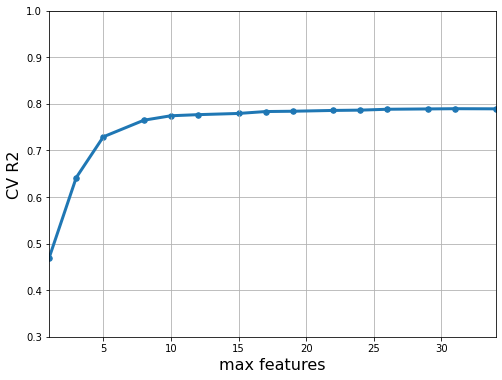

In [43]:
max_features = rf_or.cv_results_['param_max_features'].data
R2_scores = rf_or.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(max_features, R2_scores, s=30)
plt.plot(max_features, R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.xlim([1, 34])
plt.ylim([0.3, 1])

In [46]:
print(rf_or.best_params_, rf_or.best_score_)

{'max_features': 31, 'min_samples_leaf': 5, 'n_estimators': 500, 'random_state': 88} 0.7895550753062898


In [42]:
R2_rf_or=round(rf_or.score(X_train_or, y_train_or),3)
OSR2_rf_or=round(rf_or.score(X_test_or, y_test_or),3)
print('R2 :',R2_rf_or,'\nOSR2 :',OSR2_rf_or)

R2 : 0.974 
OSR2 : 0.92


In [52]:
pd.DataFrame({'Feature' : X_train_or.columns, 
              'Importance score': 100*rf_or.best_estimator_.feature_importances_}).round(1)

,Feature,Importance score
0,time,30.3
1,temp,0.9
2,dwpt,0.3
3,rhum,0.8
4,prcp,2.6
5,wdir,0.7
6,wspd,0.6
7,pres,1.2
8,business_day,1.3
9,Holiday,0.0


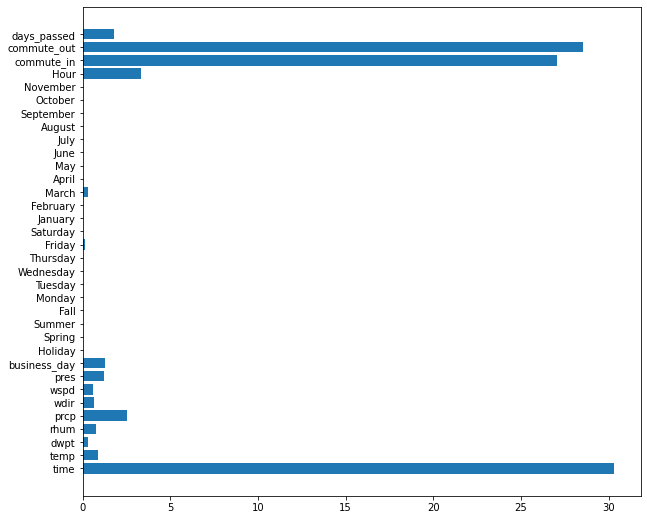

In [55]:
plt.figure(figsize=(10,9))
plt.barh(X_train_or.columns, 100*rf_or.best_estimator_.feature_importances_)
plt.show()

## Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

grid_values = {'n_estimators': np.linspace(80,200,10,dtype='int32'),
               'learning_rate': [0.01],
               'max_leaf_nodes': [3],
               'max_depth': [5],
               'min_samples_leaf': [10],
               'random_state': [88]}

gbr_or = GradientBoostingRegressor()
gbr_or = GridSearchCV(gbr_or, param_grid=grid_values, cv=5)
gbr_or.fit(X_train_or, y_train_or)

In [ ]:
R2_gbr_or=round(gbr_or.score(X_train_or, y_train_or),3)
OSR2_gbr_or=round(gbr_or.score(X_test_or, y_test_or),3)
print('R2 :',R2_rgbr_or,'\nOSR2 :',OSR2_gbr_or)

### Summary for overall models

In [ ]:
comparison_data_o=[[R2_linreg_o_c,OSR2_linreg_o_c,R2_linreg_o_r,OSR2_linreg_o_r], [R2_dtr_oc,OSR2_dtr_oc,R2_dtr_or,OSR2_dtr_or],[R2_rf_oc,OSR2_rf_oc,R2_rf_or,OSR2_rf_or]]
comparison_table_o = pd.DataFrame(data=comparison_data_o, index=['Linear reg','CART with CV','Random Forest'], columns=['R2 change','OSR2 change','R2 rental','OSR2 rental'])
comparison_table_o.style.set_properties(**{'font-size': '10pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])

### Visualisation

In [ ]:
date_time=df_test_o['datetime']
rental_true=df_test_o['rental']
rental_predict_rf=rf_or.predict(X_test_or)
rental_predict_dtr=dtr_or.predict(X_test_or)
rental_predict_linreg=linreg_o_r.predict(df_test_o)

change_true=df_test_o['change']
change_predict_rf=rf_oc.predict(X_test_oc)
change_predict_dtr=dtr_oc.predict(X_test_oc)
change_predict_linreg=linreg_o_c.predict(df_test_o)

In [ ]:
fig, subs = plt.subplots(2,figsize=(20,14))
fig.suptitle('Visualisation of results for Random Forest model on testing set').set_fontsize(24)

subs[0].set_title("Prediction of rentals").set_fontsize(20)
subs[0].plot(date_time, rental_true, label='True values')
subs[0].plot(date_time, rental_predict_rf, label='Predictions')

subs[1].set_title("Prediction of changes").set_fontsize(20)
subs[1].plot(date_time, change_true,label='True values')
subs[1].plot(date_time, change_predict_rf, label='Predictions')

subs[0].set_xlabel('date & time').set_fontsize(16)
subs[1].set_xlabel('date & time').set_fontsize(16)
subs[0].set_ylabel('rentals').set_fontsize(16)
subs[1].set_ylabel('changes').set_fontsize(16)

subs[0].legend(loc='upper right', shadow=True)
subs[1].legend(loc='upper right', shadow=True)

In [ ]:
fig, subs = plt.subplots(2,figsize=(20,14))
fig.suptitle('Visualisation of results for CART model on testing set').set_fontsize(24)

subs[0].set_title("Prediction of rentals").set_fontsize(20)
subs[0].plot(date_time, rental_true, label='True values')
subs[0].plot(date_time, rental_predict_dtr, label='Predictions')

subs[1].set_title("Prediction of changes").set_fontsize(20)
subs[1].plot(date_time, change_true,label='True values')
subs[1].plot(date_time, change_predict_dtr, label='Predictions')

subs[0].set_xlabel('date & time').set_fontsize(16)
subs[1].set_xlabel('date & time').set_fontsize(16)
subs[0].set_ylabel('rentals').set_fontsize(16)
subs[1].set_ylabel('changes').set_fontsize(16)

subs[0].legend(loc='upper right', shadow=True)
subs[1].legend(loc='upper right', shadow=True)

In [ ]:
fig, subs = plt.subplots(2,figsize=(20,14))
fig.suptitle('Visualisation of results for Linear Regression model on testing set').set_fontsize(24)

subs[0].set_title("Prediction of rentals").set_fontsize(20)
subs[0].plot(date_time, rental_true, label='True values')
subs[0].plot(date_time, rental_predict_linreg, label='Predictions')

subs[1].set_title("Prediction of changes").set_fontsize(20)
subs[1].plot(date_time, change_true,label='True values')
subs[1].plot(date_time, change_predict_linreg, label='Predictions')

subs[0].set_xlabel('date & time').set_fontsize(16)
subs[1].set_xlabel('date & time').set_fontsize(16)
subs[0].set_ylabel('rentals').set_fontsize(16)
subs[1].set_ylabel('changes').set_fontsize(16)

subs[0].legend(loc='upper right', shadow=True)
subs[1].legend(loc='upper right', shadow=True)